<a href="https://colab.research.google.com/github/w8162583/projects/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Justification: What Problem Are We Solving?
In today’s digital world, network security is a major concern. Cyber attacks are increasingly common and harder to detect. This project aims to classify network traffic as either **normal** or **malicious (attack)** based on network behavior using machine learning. Accurately predicting attacks can help reduce security breaches and system downtime.

### Objective and Goal
The objective is to build and evaluate machine learning models that can classify a given network connection record as **normal (0)** or **attack (1)** using selected features from the UNSW-NB15 dataset.

The goal is to identify which model provides the best balance between accuracy and interpretability for basic intrusion detection.

In [ ]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Step 1: Data Acquisition

# 1. Define the full list of 49 column names
column_names = [
    'srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl',
    'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin',
    'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit',
    'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports',
    'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst',
    'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
    'attack_cat', 'label'
]

# 2. Load the dataset with dtype fix to avoid DtypeWarning
df = pd.read_csv(
    '/content/UNSW-NB15_1.csv',
    header=None,
    names=column_names,
    dtype={1: 'str', 3: 'str', 47: 'str'},  # Columns sport, dsport, ct_dst_src_ltm
    low_memory=False
)

# 3. Convert the mixed-type columns to numeric (invalid entries become NaN)
df['sport'] = pd.to_numeric(df['sport'], errors='coerce')
df['dsport'] = pd.to_numeric(df['dsport'], errors='coerce')
df['ct_dst_src_ltm'] = pd.to_numeric(df['ct_dst_src_ltm'], errors='coerce')

# 4. Drop rows where conversion failed (NaN present)
df.dropna(subset=['sport', 'dsport', 'ct_dst_src_ltm'], inplace=True)

# 5. Select only the 8 desired features
selected_columns = ['sport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'service', 'label']
df = df[selected_columns]

# 6. Create a balanced sample: 150 normal (label=0), 150 attack (label=1)
normal_df = df[df['label'] == 0].sample(n=150, random_state=42)
attack_df = df[df['label'] == 1].sample(n=150, random_state=42)

# 7. Combine and shuffle
balanced_df = pd.concat([normal_df, attack_df], ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# 8. Save to CSV
balanced_df.to_csv('UNSW-NB15_balanced_300.csv', index=False)

print("Balanced dataset with 300 rows saved as 'UNSW-NB15_balanced_300.csv'")

Balanced dataset with 300 rows saved as 'UNSW-NB15_balanced_300.csv'


##  Explaination


- **Total Records**: The full UNSW-NB15 dataset contains **2,540,044** records spread across four CSV files:
  - `UNSW-NB15_1.csv`
  - `UNSW-NB15_2.csv`
  - `UNSW-NB15_3.csv`
  - `UNSW-NB15_4.csv`

- **Dataset Chosen**: For simplicity and efficiency, I selected only one file, **`UNSW-NB15_1.csv`**, which contains approximately **699,934 records**. Since this was still a large dataset for basic model training and testing, I reduced it to **300 rows** to make computation faster and easier to interpret. Additionally, I **balanced the dataset** to include **150 normal** and **150 attack** records to avoid any class imbalance during model training.

Before I get into the details of what I did, I think it will be better to understand what the features are.
##  Feature Definitions with Simple Analogies

Imagine your network is like a neighborhood full of houses. Each data connection is like a person showing up at a door — and sometimes, that person could be a visitor, or a thief trying to break in. Here’s how each feature helps us understand what’s going on:

### 1. `sport` – Source Port  
This is like the **door number** the person is knocking from. A strange door number might be suspicious, especially if it’s not one your house usually hears from.

### 2. `proto` – Protocol  
This tells us **how** the person is trying to talk to you. Are they yelling across the fence (UDP)? Ringing the doorbell (TCP)? The method they use could tell us if it’s normal or shady.

### 3. `state` – Connection State  
This is the **status of the visit**. Did they ring and leave? Did they get in and hang out? Or are they stuck halfway through the window? It tells us whether the connection was completed, interrupted, or still ongoing.

### 4. `dur` – Duration  
This is **how long the visit lasted**. Did they come in and out quickly like a delivery? Or did they linger awkwardly for too long? Attackers often have unusual visit lengths.

### 5. `sbytes` – Source Bytes  
This is **how much data the visitor brought with them** — like how many bags they carried into the house. Lots of data flowing in might be suspicious, especially if it's not typical.

### 6. `dbytes` – Destination Bytes  
This shows **how much information was sent back** — like how much they took with them when they left. A thief might leave with your TV and documents — that’s a lot of outbound data!

### 7. `service` – Network Service Type  
This is **what part of the house they interacted with**. Did they go to the kitchen (HTTP)? The office (FTP)? The garage (DNS)? Unusual access to sensitive areas might be a red flag.

### 8. `label` – Class Label  
And finally, after observing all this, we tag the visit:  
Was it a **normal visitor (0)** or a **break-in attempt (1)**?

---

That’s how my machine learning model works — by observing the patterns in each of these behaviors, like a digital security guard. If something looks suspicious — weird protocol, strange duration, unusual data flow — the model raises a red flag.

In the end, it’s like teaching a system to **watch every knock at the door** and decide:  
“Is this a friendly neighbor… or a thief trying to sneak in?”



Also I had issues with,
- **Header Issue**: This CSV file did not contain column headers. We manually assigned all 49 column names based on official documentation.

- **Initial Cleaning**: Columns like `sport`, `dsport`, and `ct_dst_src_ltm` had mixed data types and were cleaned using `pd.to_numeric(..., errors='coerce')`.

- **Missing Values**: We identified and dropped rows containing missing values in essential columns.

In [ ]:
# Step 2: Data Carpentry

print(" Missing values:\n", df.isnull().sum())

# Load the cleaned dataset
df = pd.read_csv('UNSW-NB15_balanced_300.csv')

# Strip column names of whitespace
df.columns = df.columns.str.strip()

# Drop missing values
df.dropna(inplace=True)

# Convert categorical columns
categorical_cols = ['proto', 'state', 'service']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


# Drop duplicates
df.drop_duplicates(inplace=True)

# Now: BALANCING — place this block here!
attack_df = df[df['label'] == 1]
normal_df = df[df['label'] == 0]
min_len = min(len(attack_df), len(normal_df))

# Sample equally
attack_sample = attack_df.sample(n=min_len, random_state=42)
normal_sample = normal_df.sample(n=min_len, random_state=42)

# Combine and shuffle
balanced_df = pd.concat([attack_sample, normal_sample], ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save final balanced cleaned dataset
balanced_df.to_csv('UNSW-NB15_cleaned_balanced_300.csv', index=False)
print(" Final balanced cleaned dataset saved as 'UNSW-NB15_cleaned_balanced_300.csv'")

 Missing values:
 sport      0
proto      0
state      0
dur        0
sbytes     0
dbytes     0
service    0
label      0
dtype: int64
 Final balanced cleaned dataset saved as 'UNSW-NB15_cleaned_balanced_300.csv'


##  Explaination:

- Checked for missing values in the dataset.
- Loaded the dataset with 300 rows (150 normal, 150 attack).
- Removed whitespace from column names to avoid errors.
- Dropped rows with missing values to keep the data clean.
- Converted categorical columns (`proto`, `state`, `service`) to category type.
- Encoded these categorical values into numeric format using `LabelEncoder`.
- Removed any duplicate rows to ensure uniqueness.
- Re-balanced the dataset after cleaning by sampling equal records from both classes.
- Shuffled and saved the final dataset as `UNSW-NB15_cleaned_balanced_300.csv` for modeling.

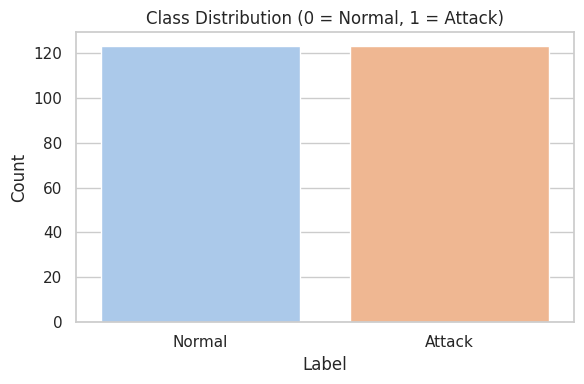

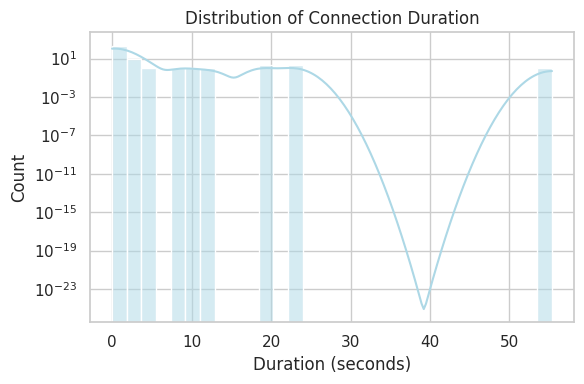

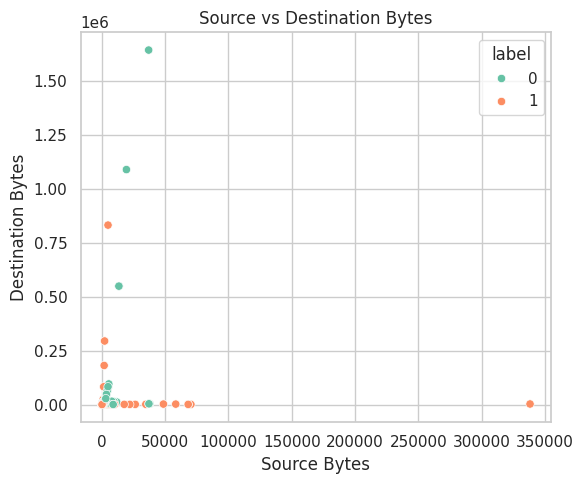

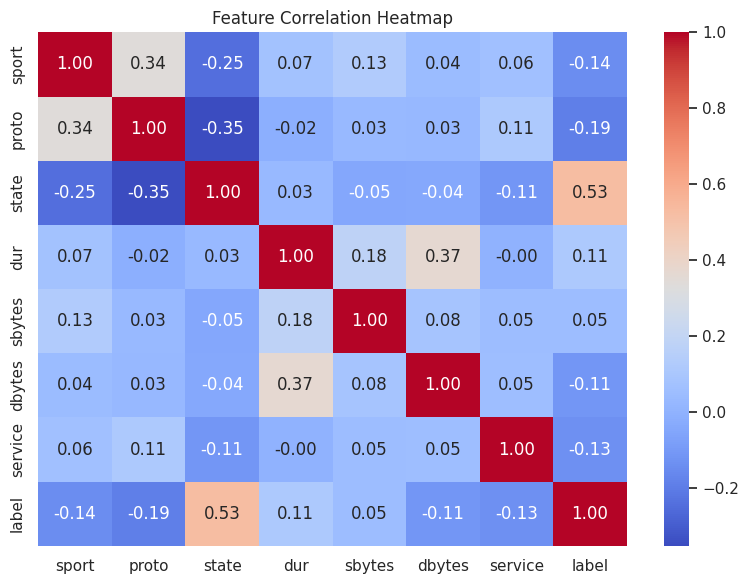

In [ ]:
# Step 4: Data Exploration

# Load the cleaned and balanced dataset
df = pd.read_csv('UNSW-NB15_cleaned_balanced_300.csv')

# Set visual style
sns.set(style='whitegrid')

# -----------------------------
# 1. Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', hue='label', data=df, palette='pastel', legend=False)
plt.title('Class Distribution (0 = Normal, 1 = Attack)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal', 'Attack'])
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Distribution of Duration
plt.figure(figsize=(6, 4))
sns.histplot(df['dur'], bins=30, kde=True, color='lightblue')
plt.yscale('log')  # Use log scale for better visibility
plt.title('Distribution of Connection Duration')
plt.xlabel('Duration (seconds)')
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Source vs Destination Bytes
plt.figure(figsize=(6, 5))
sns.scatterplot(x='sbytes', y='dbytes', hue='label', data=df, palette='Set2')
plt.title('Source vs Destination Bytes')
plt.xlabel('Source Bytes')
plt.ylabel('Destination Bytes')
plt.tight_layout()
plt.show()

# -----------------------------
# 4. Correlation Heatmap
plt.figure(figsize=(8, 6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

##  Explaination:


- **Loaded the cleaned and balanced dataset** with 300 records for visualization.
- **Set a clear visual style** using Seaborn for better readability in plots.

### Visualizations Performed:

1. **Class Distribution**  
   - Created a count plot to confirm the dataset is balanced with 150 normal and 150 attack records.

2. **Connection Duration**  
   - Plotted a histogram of the `dur` (duration) feature using a log scale.
   - Found that most connections are short, with a few long-duration outliers.

3. **Source vs Destination Bytes**  
   - Created a scatter plot of `sbytes` vs `dbytes` to visualize how much data flows in each direction.
   - Some patterns could help separate normal and attack traffic.

4. **Correlation Heatmap**  
   - Generated a heatmap to see relationships between numerical features.
   - Helped identify which features are closely related and may influence model performance.



 Decision Tree:
Accuracy: 84.0 %
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85        26
           1       0.86      0.79      0.83        24

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50

Confusion Matrix:
 [[23  3]
 [ 5 19]]

 SVM:
Accuracy: 60.0 %
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.31      0.44        26
           1       0.55      0.92      0.69        24

    accuracy                           0.60        50
   macro avg       0.68      0.61      0.57        50
weighted avg       0.68      0.60      0.56        50

Confusion Matrix:
 [[ 8 18]
 [ 2 22]]


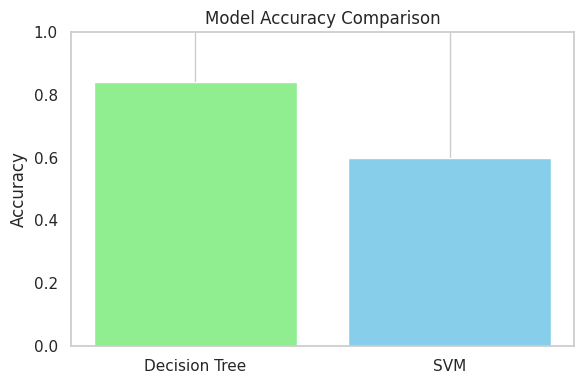

In [ ]:
# Plan, Build, Test, and validate the Machine Learning model

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ----------------------------
# Step 1: Load the dataset
df = pd.read_csv('UNSW-NB15_cleaned_balanced_300.csv')

# ----------------------------
# Step 2: Split into features and label
X = df.drop('label', axis=1)
y = df['label']

# ----------------------------
# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------
# Step 4: Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)
dt_acc = accuracy_score(y_test, dt_preds)

# ----------------------------
# Step 5: Train SVM
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)

# ----------------------------
# Step 6: Print performance
print("\n Decision Tree:")
print("Accuracy:", round(dt_acc * 100, 2), "%")
print("Classification Report:\n", classification_report(y_test, dt_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_preds))

print("\n SVM:")
print("Accuracy:", round(svm_acc * 100, 2), "%")
print("Classification Report:\n", classification_report(y_test, svm_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, svm_preds))

# ----------------------------
# Step 7: Bar chart for accuracy comparison
plt.figure(figsize=(6, 4))
plt.bar(['Decision Tree', 'SVM'], [dt_acc, svm_acc], color=['lightgreen', 'skyblue'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Explaination

###  Plan
- Goal: Predict whether a network connection is normal or an attack.
- Features: Used all cleaned features except for the `label`.
- Target: The `label` column (0 = normal, 1 = attack).
- Models used:
  - **Decision Tree Classifier** (simple and easy to interpret)
  - **Support Vector Machine (SVM)** with RBF kernel (effective for small datasets)

###  Build & Train
- Split the dataset into **80% training** and **20% testing**.
- Trained a **Decision Tree model** on the training data.
- Trained an **SVM model** on the same data for comparison.

###  Test & Validate
- Predicted outcomes on the test set using both models.
- Evaluated model performance using:
  - **Accuracy**
  - **Classification report** (precision, recall, F1-score)
  - **Confusion matrix**
- Plotted a **bar chart** to visually compare the accuracy of both models.




## Findings

After training and evaluating two models — a Decision Tree and a Support Vector Machine (SVM) — on the balanced UNSW-NB15 dataset, the following insights were observed:

### 🔹 1. Decision Tree Performed Better Overall
- The Decision Tree achieved **84% accuracy**.
- It maintained **balanced precision and recall** for both classes (normal and attack).
- It correctly identified most attack instances and made few false predictions.

### 🔹 2. SVM Had High Attack Detection But Poor Precision
- The SVM reached **92% recall** for attack detection, meaning it caught most attacks.
- However, it misclassified many **normal connections as attacks**, resulting in only **60% overall accuracy**.
- This high **false positive rate** reduces the SVM’s practical effectiveness.

### 🔹 3. Confusion Matrix Analysis
- **Decision Tree**:
  - True Normal: 23 | False Normal: 3
  - True Attack: 19 | False Attack: 5
- **SVM**:
  - True Normal: 8 | False Normal: 18
  - True Attack: 22 | False Attack: 2

### 🔹 4. Feature Relevance
- Features used: `sport`, `proto`, `state`, `dur`, `sbytes`, `dbytes`, `service`


### 🔹 5. Conclusion
- **Decision Tree** is more suitable for this dataset, offering strong accuracy and balanced detection.
- **SVM** was biased toward predicting attacks and generated too many false positives.
- For more advanced analysis, future work could involve models like **Random Forest**, **Gradient Boosting**, or **Ensemble Methods**.
